In [1]:
# prepare packages
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data')

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


# Network

In [3]:
# input placeholders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def generator(z, output_dim, reuse=False, initial_feature_size=512, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        feature_map_size = initial_feature_size
        
        # 1. Fully connected layer (make 3x3x512)
        first_layer_units = 3 * 3 * feature_map_size
        x1 = tf.layers.dense(inputs=z, units=first_layer_units, activation=None, use_bias=True)
        # reshape as convolutional layer
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        # add batch normalization
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_training)
        # add reaky relu activation
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. convolutional layer (make 7x7x256)
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. convolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer, 28x28x1
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=output_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

In [5]:
def discriminator(x, reuse=False, initial_filter_size=64, alpha=0.2, is_training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # starting variable
        filters = initial_filter_size
        # Input layer is 28x28x1
        
        # make 14x14x64
        x1 = tf.layers.conv2d(inputs=x, filters=filters, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filters, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filters, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattened_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattened_layer, units=1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

# Build

In [8]:
class DCGAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r', aspect='equal')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

# Train

In [31]:
def train(net, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for ii in range(mnist.train.num_examples//batch_size):
                steps += 1
                
                # no need labels
                batch_x, _ = mnist.train.next_batch(batch_size)
                
                # Get images rescale to pass to D
                batch_images = batch_x.reshape(-1, 28, 28, 1)
                batch_images = batch_images*2 -1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 1, reuse=True, is_training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

# Hyperparameters

In [32]:
real_size = (28,28,1)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 30
alpha = 0.2
beta1 = 0.5

# Create the network
net = DCGAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/30... Discriminator Loss: 0.4105... Generator Loss: 1.5582
Epoch 1/30... Discriminator Loss: 0.3334... Generator Loss: 1.5696
Epoch 1/30... Discriminator Loss: 1.7099... Generator Loss: 0.2487
Epoch 1/30... Discriminator Loss: 1.0554... Generator Loss: 7.1584
Epoch 1/30... Discriminator Loss: 0.5287... Generator Loss: 3.9755
Epoch 1/30... Discriminator Loss: 0.7870... Generator Loss: 0.9860
Epoch 1/30... Discriminator Loss: 0.4082... Generator Loss: 1.8891
Epoch 1/30... Discriminator Loss: 0.5582... Generator Loss: 1.4439
Epoch 1/30... Discriminator Loss: 1.3612... Generator Loss: 5.7441
Epoch 1/30... Discriminator Loss: 0.5876... Generator Loss: 2.5119


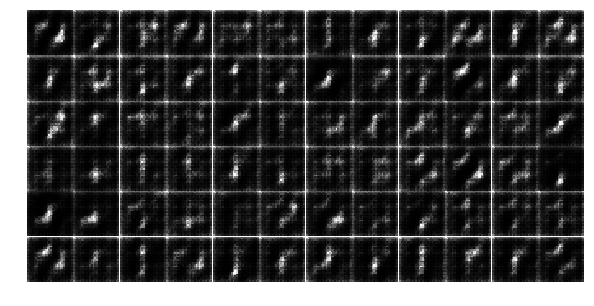

Epoch 1/30... Discriminator Loss: 0.6687... Generator Loss: 1.8323
Epoch 1/30... Discriminator Loss: 0.4741... Generator Loss: 2.0624
Epoch 1/30... Discriminator Loss: 0.4674... Generator Loss: 2.3576
Epoch 1/30... Discriminator Loss: 0.8712... Generator Loss: 1.1065
Epoch 1/30... Discriminator Loss: 0.7322... Generator Loss: 1.2325
Epoch 1/30... Discriminator Loss: 1.1435... Generator Loss: 0.7664
Epoch 1/30... Discriminator Loss: 0.7636... Generator Loss: 2.2747
Epoch 1/30... Discriminator Loss: 0.9368... Generator Loss: 0.9875
Epoch 1/30... Discriminator Loss: 0.9765... Generator Loss: 1.4284
Epoch 1/30... Discriminator Loss: 0.7285... Generator Loss: 1.0945


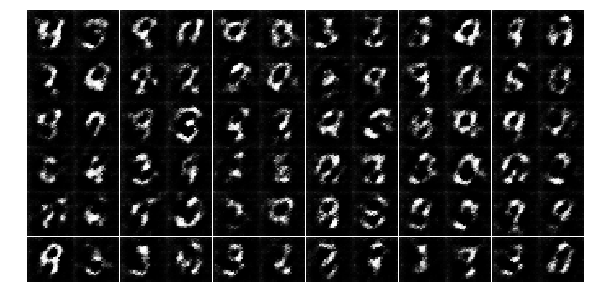

Epoch 1/30... Discriminator Loss: 0.8278... Generator Loss: 2.5063
Epoch 1/30... Discriminator Loss: 0.7416... Generator Loss: 0.9518
Epoch 1/30... Discriminator Loss: 0.6987... Generator Loss: 1.3218
Epoch 1/30... Discriminator Loss: 1.1332... Generator Loss: 0.5629
Epoch 1/30... Discriminator Loss: 0.6601... Generator Loss: 1.5156
Epoch 1/30... Discriminator Loss: 1.0216... Generator Loss: 2.7101


KeyboardInterrupt: 

In [33]:
losses, samples = train(net, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))